## 0. Package Installation

In [3]:
!pip install apscheduler

     |████████████████████████████████| 59 kB 8.4 MB/s  eta 0:00:01
     |████████████████████████████████| 70 kB 12.8 MB/s eta 0:00:01
     |████████████████████████████████| 341 kB 74.4 MB/s eta 0:00:01
You should consider upgrading via the '/home/ubuntu/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [36]:
!pip install torch

     |███████████████▌                | 428.0 MB 132.1 MB/s eta 0:00:04

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |██████████████████▉             | 519.6 MB 112.9 MB/s eta 0:00:04

     |███████████████████             | 524.8 MB 112.9 MB/s eta 0:00:04

     |███████████████████▎            | 530.7 MB 112.9 MB/s eta 0:00:04

     |███████████████████▌            | 536.6 MB 112.9 MB/s eta 0:00:04

     |███████████████████▊            | 542.6 MB 112.9 MB/s eta 0:00:04

     |████████████████████            | 548.6 MB 112.9 MB/s eta 0:00:03

     |████████████████████▏           | 554.5 MB 112.9 MB/s eta 0:00:03

     |████████████████████▍           | 560.6 MB 112.9 MB/s eta 0:00:03

     |████████████████████▌           | 565.9 MB 112.9 MB/s eta 0:00:03

     |████████████████████▋           | 569.4 MB 112.9 MB/s eta 0:00:03

     |███████████████████████████▏    | 749.9 MB 127.5 MB/s eta 0:00:02

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |██████████████████████████████▊ | 845.7 MB 125.8 MB/s eta 0:00:01

     |███████████████████████████████ | 852.2 MB 125.8 MB/s eta 0:00:01

     |████████████████████████████████| 881.9 MB 1.5 kB/s s eta 0:00:01
You should consider upgrading via the '/home/ubuntu/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [38]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 17.7 MB/s eta 0:00:01
     |████████████████████████████████| 880 kB 99.6 MB/s eta 0:00:01
     |████████████████████████████████| 67 kB 9.1 MB/s  eta 0:00:01
     |████████████████████████████████| 6.6 MB 104.5 MB/s eta 0:00:01
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895254 sha256=30c5080e6abc5ea7ba82759297fc0808e42db0cedf16d67ebea75ff7100e21aa
  Stored in directory: /home/lab01/.cache/pip/wheels/4c/64/31/e9900a234b23fb3e9dc565d6114a9d6ff84a72dbdd356502b4
Successfully built sacremoses
You should consider upgrading via the '/home/ubuntu/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## 1. Modeling

### 1) 토크나이저 및 모델 정의

In [1]:
%%time

# 토크나이저 및 모델 로드
import torch
from transformers import PreTrainedTokenizerFast
from transformers import BartForConditionalGeneration

tokenizer = PreTrainedTokenizerFast.from_pretrained('gogamza/kobart-summarization')
model = BartForConditionalGeneration.from_pretrained('gogamza/kobart-summarization')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BartTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


CPU times: user 2.46 s, sys: 771 ms, total: 3.23 s
Wall time: 5.14 s


### 2) 전이학습

#### 2-1) Preprocessing for input shape 클래스 정의  

In [2]:
import torch 
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        item = self.data[index]
        input_text = item['input_text']
        target_text = item['target_text']

        return input_text, target_text

    def __len__(self):
        return len(self.data)

#### 2-2) 학습 데이터 셋 로드 (50개 기사 원문 및 요약데이터)

In [3]:
#!git clone https://github.com/theeluwin/sci-news-sum-kr-50.git

In [4]:
import pandas as pd
import numpy as np
import os
import json

data_list = []
topic_list = []
cnt = 0
data_path = '/home/lab01/sci-news-sum-kr-50/data/'
folders = os.listdir(data_path)
print(len(folders))
for i in range(0,len(folders)):
    if folders[i].split('.')[1] == 'json':
        file = data_path+folders[i]
        with open(file, 'r') as file:
            data = json.load(file)
            data_str = ''.join(data['sentences'])
            data_list.append(data_str)
            topic = []
            for i in data['summaries']:
                topic.append(data['sentences'][i])
            topic_str = ''.join(topic)
            topic_list.append(topic_str)
            
# dict 형태로 합치기
test_dataset = {"input_text" : data_list, "target_text" :  topic_list}

50


In [5]:
data =[]
for i in range(50):
    data += [{'input_text': test_dataset.get('input_text')[i],
     'target_text': test_dataset.get('target_text')[i]}]

#### 2-3) 데이터셋 인스턴스 생성

In [6]:
dataset = MyDataset(data)

# 데이터셋의 요소에 접근하여 출력
for index in range(len(dataset)):
    input_text, target_text = dataset[index]
    print(input_text, target_text)


애플 '시리'·SKT '누구' 등음성인식 기술 활용 잇따라소음속 음성인식 등은 과제아이폰에서 시리(Siri)를 작동시킨 화면SK텔레콤의 음성인식 기반 인공지능 서비스 기기 ‘누구(NUGU)’“다른 누구도 당신처럼 사랑한 적은 없어요.” “저도요이제 우리는 사랑하는 법을 아는 거겠죠.”영화 ‘허(Her·2014)’에서 주인공 ‘테어도르’와 음성인식 운영체제(OS) ‘사만다’가 나누는 대화다영화에서 그리는 기술은 단순히 음성을 인식하는 차원을 넘어 문맥 속에서 감정과 의도를 읽고 교감까지 한다기계가 인간에 가깝게 진화하는 것으로 음성인식 기술의 궁극적 발전 단계에 속한다애플 ‘시리(Siri)’, SK텔레콤 ‘누구(NUGU)’ 등이 완벽하지는 않지만 현실 속의 사만다라 할 수 있다일정을 챙기는 비서 역할을 비롯해 자동차 내비게이션·채팅봇 등으로 음성인식 기술이 활용되고 있다삼성전자는 지난달 시리를 만든 비브랩스(VIV Labs)를 인수하고 새로운 서비스 출시를 예고하며 음성인식 기술에 대한 관심을 고조시켰다그렇다면 음성인식은 어떻게 작동할까음성인식은 사람 입에서 나온 음성신호를 자동으로 인식해 문자열로 변환해주는 과정 혹은 기술이다사람이 의사소통하듯 듣기와 인지의 과정을 거친다박범근 연구성과실용화진흥원 매니저는 “음성인식은 음성으로부터 추출한 독특한 특성을 이용하는 인식기술”이라며 “비강과 구강·구강 모양 등에 의한 음성학적 특성을 이용한다”고 설명했다음성인식 단계는 크게 음성인식(전처리)→자연어(일상 언어) 이해→자연어 응답→음성합성으로 이어진다생활 속 듣기에 해당하는 전처리에서는 이용자가 “오늘 날씨 어때”라고 물으면 기계가 ‘O’‘ㅗ’ 등 음운마다 다른 주파수를 통해 질문이 날씨라는 것을 인지한다자연어 이해에서는 질문의 의도를 알고 기상청 등을 통해 현재 날씨·기온 등을 파악한다자연어 응답에서는 음운을 조합해 문장으로 변환하고 음성합성에서는 문장을 읽어준다전처리시 주파수 등 주기적으로 반복되는 패턴을 추출하고 이를 미리 수집된 음성 모델 데이터베이스(DB)와 

#### 2-4) Preprocessing for Tensor 함수 정의

In [7]:
def preprocess(data):
    
    for index in range(len(dataset)):
        input_text, target_text = dataset[index]
        #print('input :', input_text, 'target :',target_text)
    

    # 입력 및 대상 텍스트를 토큰화합니다.
    input_tokens = tokenizer.encode_plus(input_text, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
    target_tokens = tokenizer.encode_plus(target_text, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
    
    # 토큰화된 입력과 대상을 텐서로 변환합니다.
    input_ids = input_tokens['input_ids'].squeeze()
    input_attention_mask = input_tokens['attention_mask'].squeeze()
    
    target_ids = target_tokens['input_ids'].squeeze()
    target_attention_mask = target_tokens['attention_mask'].squeeze()
    
    return {'input_ids': input_ids, 'attention_mask': input_attention_mask, 'target_ids': target_ids, 'target_attention_mask': target_attention_mask}


In [8]:
train_dataset =[]
for i in range(len(dataset.data)):
    train_dataset.append(preprocess(dataset.data[i]))

In [9]:
#train_dataset

In [10]:
#len(train_dataset[1]['target_ids'])

#### 2-5) train, test set 분리 (40:10)

In [11]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(train_dataset, random_state = 42, test_size = 0.2)

In [12]:
#len(test_dataset)

#### 2-6) 데이터 로더 생성

In [13]:
import torch

# Set the batch size

BATCH_SIZE = 8

# Convert train_dataset into a DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           num_workers=0)

#Convert val_dataset into a DataLoader
val_loader = torch.utils.data.DataLoader(test_dataset, 
                                         batch_size=BATCH_SIZE,
                                         shuffle=False,
                                         num_workers=0)

In [14]:
#len(train_loader.dataset[0].get('input_ids'))

In [15]:
#train_loader.dataset

#### 2-7) 옵티마이저, 손실함수 정의

## AdamW

In [16]:
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

learning_rate = 1e-5
weight_decay = 0.0 #0.01
adam_epsilon = 1e-8
#warmup_steps = 8
#max_steps = 80

# Define optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=adam_epsilon, weight_decay=weight_decay)
#scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=max_steps)

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=model.config.pad_token_id)

/home/lab01/.local/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


#### 2-8) 전이학습

In [16]:
import torch

# GPU 사용 가능 여부 확인
if torch.cuda.is_available():
    # GPU를 디바이스로 설정
    device = torch.device("cuda")
else:
    # CPU를 디바이스로 설정
    device = torch.device("cpu")

In [17]:
device

device(type='cuda')

In [19]:
model.named_parameters

<bound method Module.named_parameters of BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(30000, 768, padding_idx=3)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(30000, 768, padding_idx=3)
      (embed_positions): BartLearnedPositionalEmbedding(1028, 768)
      (layers): ModuleList(
        (0): BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_

In [20]:
import torch.nn as nn

# Freeze the initial layers
for param in model.parameters():
     param.requires_grad = False

# Unfreeze specific layers or groups of layers
for name, param in model.named_parameters():
    if "encoder.layer" in name:
        param.requires_grad = True

# Define your downstream task classifier
#classifier = nn.Linear(model.config.hidden_size, num_classes)

# # Create an optimizer for the trainable parameters
# optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

# # # Training loop
# # for epoch in range(num_epochs):
# #     for batch in data_loader:
#         inputs = tokenizer(batch["text"], padding=True, truncation=True, return_tensors="pt")
#         outputs = model(**inputs)
#         hidden_states = outputs.last_hidden_state

#         # Pass the hidden states through your classifier
#         logits = classifier(hidden_states)

#         # Compute the loss and update the classifier
#         loss = criterion(logits, batch["labels"])
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()


In [21]:
%%time 
loss_t =[] 
loss_e =[]

import torch

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the number of epochs
NUM_EPOCHS = 10

# Move the model to the device
model = model.to(device)


### Set the optimizer
### optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Set the best loss and best model state
best_loss = float('inf')
best_model_state = None

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()  # Set the model to training mode
    train_loss = 0  # Initialize training loss
    
    for batch in train_loader:
        # Move the batch to the device
        input_ids = batch['input_ids'].to(device)
        target_ids = batch['target_ids'].to(device)     
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(input_ids=input_ids, decoder_input_ids=target_ids)
        
        # Compute the loss
        loss = loss_fn(outputs.logits.view(-1, outputs.logits.shape[-1]), target_ids.contiguous().view(-1))
        
        # Backward pass
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Update training loss
        train_loss += loss.item()
    
    # Calculate average training loss per epoch
    train_loss /= len(train_loader)
    
    # Print training loss
    print('Epoch [{}/{}], Training Loss: {:.4f}'.format(epoch+1, NUM_EPOCHS, train_loss))
    
   
    # Evaluation
    model.eval()  # Set the model to evaluation mode
    eval_loss = 0  # Initialize evaluation loss
    
    with torch.no_grad():
        for batch in val_loader:
            # Move the batch to the device
            input_ids = batch['input_ids'].to(device)
            target_ids = batch['target_ids'].to(device)
            
            # Forward pass
            outputs = model(input_ids=input_ids, decoder_input_ids=target_ids)
            
            # Compute the loss
            loss = loss_fn(outputs.logits.view(-1, outputs.logits.shape[-1]), target_ids.contiguous().view(-1))
            
            # Update evaluation loss
            eval_loss += loss.item()
    
    # Calculate average evaluation loss per epoch
    eval_loss /= len(val_loader)
    
    # Print evaluation loss
    print('Epoch [{}/{}], Evaluation Loss: {:.4f}'.format(epoch+1, NUM_EPOCHS, eval_loss))
    
    loss_t.append(train_loss)
    loss_e.append(eval_loss)

    # Check if the current model has the best loss
    if train_loss < best_loss:
        best_loss = train_loss
        best_model_state = model.state_dict()
        


# Load the best model state
model.load_state_dict(best_model_state)
#torch.save(model.state_dict(), './output/saved_model')

Epoch [1/10], Training Loss: 7.8044
Epoch [1/10], Evaluation Loss: 6.0585
Epoch [2/10], Training Loss: 5.3392
Epoch [2/10], Evaluation Loss: 4.7698
Epoch [3/10], Training Loss: 4.3921
Epoch [3/10], Evaluation Loss: 3.6716
Epoch [4/10], Training Loss: 3.4006
Epoch [4/10], Evaluation Loss: 2.4274
Epoch [5/10], Training Loss: 2.4187
Epoch [5/10], Evaluation Loss: 1.4431
Epoch [6/10], Training Loss: 1.7346
Epoch [6/10], Evaluation Loss: 1.0035
Epoch [7/10], Training Loss: 1.2366
Epoch [7/10], Evaluation Loss: 0.6626
Epoch [8/10], Training Loss: 0.8962
Epoch [8/10], Evaluation Loss: 0.4133
Epoch [9/10], Training Loss: 0.6380
Epoch [9/10], Evaluation Loss: 0.2545
Epoch [10/10], Training Loss: 0.4768
Epoch [10/10], Evaluation Loss: 0.1673
CPU times: user 44.5 s, sys: 11.4 s, total: 55.9 s
Wall time: 55.5 s


#### 2-9) 시각화

In [25]:
loss_t

[7.80438985824585,
 5.339153575897217,
 4.39205150604248,
 3.400577688217163,
 2.4187358379364015,
 1.7346130847930907,
 1.2365791082382203,
 0.8961946964263916,
 0.6379794001579284,
 0.47679429054260253]

In [27]:
loss_e

[6.0584986209869385,
 4.769808769226074,
 3.6716318130493164,
 2.4273651838302612,
 1.4430708289146423,
 1.003528892993927,
 0.6625665128231049,
 0.41325998306274414,
 0.2544800490140915,
 0.16733217984437943]

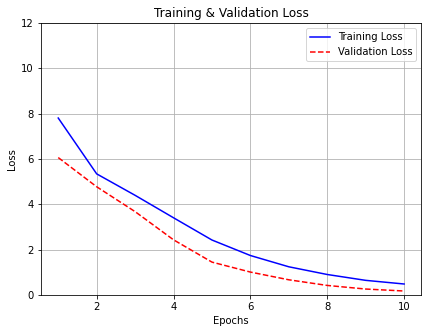

In [31]:
import matplotlib.pyplot as plt

epochs = range(1, NUM_EPOCHS +1)

plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss_t, 'b-')
plt.plot(epochs, loss_e, 'r--')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0,12])
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()

plt.show()

## 3. 모델적용

In [13]:
import pandas as pd
import numpy as np
import os
import json

data_list = []
topic_list = []
data_path = '/home/lab01/sci-news-sum-kr-50/data/'
forders = os.listdir(data_path)
print(len(forders))
for i in range(0,len(forders)):
    if forders[i].split('.')[1] == 'json':
        file = data_path+forders[i]
        with open(file, 'r') as file:
            data = json.load(file)
            data_str = ''.join(data['sentences'])
            data_list.append(data_str)
            topic = []
            for i in data['summaries']:
                topic.append(data['sentences'][i])
            topic_str = ''.join(topic)
            topic_list.append(topic_str)
            
# dict 형태로 합치기
test_dataset = data_list
target_text = topic_list

50


In [14]:
test_dataset[0]

"애플 '시리'·SKT '누구' 등음성인식 기술 활용 잇따라소음속 음성인식 등은 과제아이폰에서 시리(Siri)를 작동시킨 화면SK텔레콤의 음성인식 기반 인공지능 서비스 기기 ‘누구(NUGU)’“다른 누구도 당신처럼 사랑한 적은 없어요.” “저도요이제 우리는 사랑하는 법을 아는 거겠죠.”영화 ‘허(Her·2014)’에서 주인공 ‘테어도르’와 음성인식 운영체제(OS) ‘사만다’가 나누는 대화다영화에서 그리는 기술은 단순히 음성을 인식하는 차원을 넘어 문맥 속에서 감정과 의도를 읽고 교감까지 한다기계가 인간에 가깝게 진화하는 것으로 음성인식 기술의 궁극적 발전 단계에 속한다애플 ‘시리(Siri)’, SK텔레콤 ‘누구(NUGU)’ 등이 완벽하지는 않지만 현실 속의 사만다라 할 수 있다일정을 챙기는 비서 역할을 비롯해 자동차 내비게이션·채팅봇 등으로 음성인식 기술이 활용되고 있다삼성전자는 지난달 시리를 만든 비브랩스(VIV Labs)를 인수하고 새로운 서비스 출시를 예고하며 음성인식 기술에 대한 관심을 고조시켰다그렇다면 음성인식은 어떻게 작동할까음성인식은 사람 입에서 나온 음성신호를 자동으로 인식해 문자열로 변환해주는 과정 혹은 기술이다사람이 의사소통하듯 듣기와 인지의 과정을 거친다박범근 연구성과실용화진흥원 매니저는 “음성인식은 음성으로부터 추출한 독특한 특성을 이용하는 인식기술”이라며 “비강과 구강·구강 모양 등에 의한 음성학적 특성을 이용한다”고 설명했다음성인식 단계는 크게 음성인식(전처리)→자연어(일상 언어) 이해→자연어 응답→음성합성으로 이어진다생활 속 듣기에 해당하는 전처리에서는 이용자가 “오늘 날씨 어때”라고 물으면 기계가 ‘O’‘ㅗ’ 등 음운마다 다른 주파수를 통해 질문이 날씨라는 것을 인지한다자연어 이해에서는 질문의 의도를 알고 기상청 등을 통해 현재 날씨·기온 등을 파악한다자연어 응답에서는 음운을 조합해 문장으로 변환하고 음성합성에서는 문장을 읽어준다전처리시 주파수 등 주기적으로 반복되는 패턴을 추출하고 이를 미리 수집된 음성 모델 데이터베이스(DB)와

In [18]:
%%time

model_out = []

for i in range(0,len(test_dataset)):
    text = test_dataset[i]
    text = text.replace('\n', ' ')
    model.to(device)
    raw_input_ids = tokenizer.encode(text)
    input_ids = [tokenizer.bos_token_id] + raw_input_ids + [tokenizer.eos_token_id]
    max_length=512
    # 입력 문장 길이 제한
    if len(input_ids) > max_length:
        input_ids = input_ids[:max_length]

    summary_ids = model.generate(torch.tensor([input_ids]).to(device), repetition_penalty=2.0, num_beams=4, 
                                 min_length = 50, max_length=512,  eos_token_id=1,  early_stopping=True)
    summary_news = tokenizer.decode(summary_ids.squeeze().tolist(), skip_special_tokens=True)

    model_out.append(summary_news)

CPU times: user 34.3 s, sys: 1.29 s, total: 35.6 s
Wall time: 35.6 s


## 5. Performace Evaluation

### metric 1. Rouge

In [25]:
from rouge import Rouge
# avg 구하기 전 변수 초기화
total_1_r = 0
total_1_p = 0
total_1_f = 0
total_2_r = 0
total_2_p = 0
total_2_f = 0
total_l_r = 0
total_l_p= 0
total_l_f = 0
for i in range(0, len(model_out)):
    reference = [target_text[i]]
    rouge = Rouge()
    t= rouge.get_scores([model_out[i]], reference , avg = True)
    total_1_r += t['rouge-1']['r']
    total_1_p += t['rouge-1']['p']
    total_1_f += t['rouge-1']['f']
    total_2_r += t['rouge-2']['r']
    total_2_p += t['rouge-2']['p']
    total_2_f += t['rouge-2']['f']
    total_l_r += t['rouge-l']['r']
    total_l_p += t['rouge-l']['p']
    total_l_f += t['rouge-l']['f']
total_dict ={'rouge-1':{'r':total_1_r/50, 'p':total_1_p/50,'f':total_1_f/50},
             'rouge-2':{'r':total_2_r/50, 'p':total_2_p/50,'f':total_2_f/50},
             'rouge-l':{'r':total_l_r/50, 'p':total_l_p/50,'f':total_l_f/50}}
print(total_dict)

{'rouge-1': {'r': 0.32861736503240235, 'p': 0.6542868123317873, 'f': 0.41936051623238974}, 'rouge-2': {'r': 0.2697835360660652, 'p': 0.5723695864972668, 'f': 0.3491874316061643}, 'rouge-l': {'r': 0.3010578315394084, 'p': 0.5967274180449197, 'f': 0.38311955165403405}}


### metric2. BLEU 

In [21]:
from konlpy.tag import Mecab
#from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu

from konlpy.tag import Mecab
from nltk.translate.bleu_score import corpus_bleu

mecab = Mecab()
totat_score1 = 0
totat_score2 = 0
totat_score3 = 0
totat_score4 = 0
BLEU_score = 0
BLEU_4_score = 0 
for i in range(0, len(model_out)):
    reference = [target_text[i]]
    reference = [[mecab.morphs(s) for s in reference]]
    candidate = [mecab.morphs(model_out[i])]

    print(f'reference: {reference}')
    print('candidate:', candidate)
    print('BLEU:', corpus_bleu(reference, candidate))

    BLEU_score += corpus_bleu(reference, candidate)
    score1 = corpus_bleu(reference, candidate, weights=(1, 0, 0, 0))
    score2 = corpus_bleu(reference, candidate, weights=(0, 1, 0, 0))
    score3 = corpus_bleu(reference, candidate, weights=(0, 0, 1, 0))
    score4 = corpus_bleu(reference, candidate, weights=(0, 0, 0, 1))

    print("Individual 1-gram : ", score1)
    totat_score1 += score1
    totat_score2 += score2
    totat_score3 += score3
    totat_score4 += score4
    print("Individual 2-gram : ", score2)  
    print("Individual 3-gram : ", score3)  
    print("Individual 4-gram : ", score4)  

    #기본적으로 sentence_bleu() 함수는 BLEU-4라고도 하는 누적 4그램 BLEU 점수를 계산합니다. 
    #BLEU-4의 가중치는 다음과 같습니다.
    #이것이 n-gram 가중치를 추가하지 않고 얻은 정확한 점수입니다.
    score = corpus_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
    BLEU_4_score += score
    
    print("BLEU-4 : ", score)
    print('BLEU AVG:', BLEU_4_score/50)
print("Individual 1-gram AVG: ", totat_score1/50)
print("Individual 2-gram AVG: ", totat_score2/50)  
print("Individual 3-gram AVG: ", totat_score3/50)  
print("Individual 4-gram AVG: ", totat_score4/50) 
print("BLEU-4 AVG : ", score)

reference: [[['기계', '가', '인간', '에', '가깝', '게', '진화', '하', '는', '것', '으로', '음성', '인식', '기술', '의', '궁극', '적', '발전', '단계', '에', '속한다', '삼성전자', '는', '지난달', '시리', '를', '만든', '비브', '랩스', '(', 'VIV', 'Labs', ')', '를', '인수', '하', '고', '새로운', '서비스', '출시', '를', '예고', '하', '며', '음성', '인식', '기술', '에', '대한', '관심', '을', '고조', '시켰', '다', '박범', '근', '연구', '성', '과', '실용', '화', '진', '흥원', '매니저', '는', '“', '음성', '인식', '은', '음성', '으로부터', '추출', '한', '독특', '한', '특성', '을', '이용', '하', '는', '인식', '기술', '”', '이', '라며', '“', '비강', '과', '구강', '·', '구강', '모양', '등', '에', '의한', '음성학', '적', '특성', '을', '이용', '한다', '”', '고', '설명', '했', '다']]]
candidate: [['음성', '인식', '기반', '인공지능', '서비스', '인', "'", '누구', '(', 'NUGU', ')', "'", '는', '단순히', '음성', '을', '인식', '하', '는', '차원', '을', '넘', '어', '문맥', '속', '에서', '감정', '과', '의도', '를', '읽', '고', '교감', '까지', '한다', '기계', '가', '인간', '에', '가깝', '게', '진화', '하', '는', '것', '으로', '음성', '인식', '기술', '의', '궁극', '적', '발전', '단계', '에', '속한다', '애플', '‘', '시리', '(', 'Siri', ')', '’,', 'SK', '텔레콤',

Individual 1-gram :  0.44176706827309237
Individual 2-gram :  0.29577464788732394
Individual 3-gram :  0.26814516129032256
Individual 4-gram :  0.2585858585858586
BLEU-4 :  0.3085192413905858
BLEU AVG: 0.14007603627041976
reference: [[['국내', '연구', '팀', ',', '특정', '단백질', '증가', '현상', '찾아내', '…', '폐암', '조기', '진단', '키트', '·', '신약', '개발', '기대', '[', '아시아', '경제', '정종오', '기자', ']', '폐암', '을', '조기', '에', '진단', '할', '수', '있', '는', '생화학', '마커', '를', '국내', '연구', '팀', '이', '발견', '했', '습니다', '폐암', '환자', '의', '92', '.', '5', '%', '에서', "'", 'USE', '1', "'", '단백질', '이', '증가', '돼', '있', '고', '이', '중', '13', '%', '에서', '는', 'USE', '1', '유전자', '에', '돌연변이', '가', '발생', '해', '폐암', '이', '발생', '한다는', '사실', '을', '발견', '했', '습니다', '수십', '년', '동안', '진단', '과', '치료', '기술', '이', '개발', '됐', '는데', '특별', '한', '자각', '증상', '이', '없', '고', '대부분', '진행', '암', '또는', '다른', '부위', '에', '까지', '도', '전이', '된', '상태', '에서', '발견', '돼', '폐암', '환자', '의', '완치', '율', '은', '30', '%', '이하', '로', '낮', '습니다', '폐암', '진단', '을', '위해', '바이오', '

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [24]:
model_out[1]
#test_dataset[0]
#target_text[0]

'3일 한국과학기술회관에서 열린 `기초연구 경쟁력, 질적 혁명에서부터`라는 주제 정책포럼에서 이민형 STEPI 선임연구위원은 우리나라 기초연구 경쟁력은 영향을 미치는 성과가 부족해 과학적 진보, 인류복지 기여 등 국내 경제사회적 문제해결 등 목적을 명시할 필요가 있다고 주장했다.'